In [55]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [56]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Gulliver Corpus**

In [57]:
fileGulliver = open("gulliver.txt", "r")
gulliver = fileGulliver.read()
print(gulliver[:1000])
new_gulliver = ""
for char in gulliver:
    if char in ['$', '%', '&', 'æ', 'œ', '–', '—', '‘', '’', '“', '”', '•', '™']:
        continue
    new_gulliver += char.lower()

characters = sorted(list(set(new_gulliver)))
print(len(new_gulliver))
print(len(characters))
print(characters)

PART I. A VOYAGE TO LILLIPUT.


CHAPTER I.

The author gives some account of himself and family. His first
inducements to travel. He is shipwrecked, and swims for his life, gets
safe on shore in the country of Lilliput; is made a prisoner, and
carried up the country.


My father had a small estate in Nottinghamshire; I was the third of
five sons. He sent me to Emanuel College in Cambridge at fourteen years
old, where I resided three years, and applied myself close to my
studies; but the charge of maintaining me, although I had a very scanty
allowance, being too great for a narrow fortune, I was bound apprentice
to Mr. James Bates, an eminent surgeon in London, with whom I continued
four years. My father now and then sending me small sums of money, I
laid them out in learning navigation, and other parts of the
mathematics, useful to those who intend to travel, as I always believed
it would be, some time or other, my fortune to do. When I left Mr.
Bates, I went down to my father: where, 

In [58]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["+"] = 0 ## Pad Character
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '+',
 1: '\n',
 2: ' ',
 3: '!',
 4: "'",
 5: '(',
 6: ')',
 7: '*',
 8: ',',
 9: '-',
 10: '.',
 11: '/',
 12: '0',
 13: '1',
 14: '2',
 15: '3',
 16: '4',
 17: '5',
 18: '6',
 19: '7',
 20: '8',
 21: '9',
 22: ':',
 23: ';',
 24: '?',
 25: '[',
 26: ']',
 27: '_',
 28: 'a',
 29: 'b',
 30: 'c',
 31: 'd',
 32: 'e',
 33: 'f',
 34: 'g',
 35: 'h',
 36: 'i',
 37: 'j',
 38: 'k',
 39: 'l',
 40: 'm',
 41: 'n',
 42: 'o',
 43: 'p',
 44: 'q',
 45: 'r',
 46: 's',
 47: 't',
 48: 'u',
 49: 'v',
 50: 'w',
 51: 'x',
 52: 'y',
 53: 'z'}


![](./MLPToken.svg)

## Generating the Training Samples

![](./media/MLPToken.svg)

In [59]:
block_size = 20
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_gulliver)):
  ix = stoi[new_gulliver[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [60]:
X.shape, Y.shape

(torch.Size([588307, 20]), torch.Size([588307]))

In [77]:
# Embedding layer for the context
emb_dim = 50
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [78]:
emb.weight.shape

torch.Size([54, 50])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

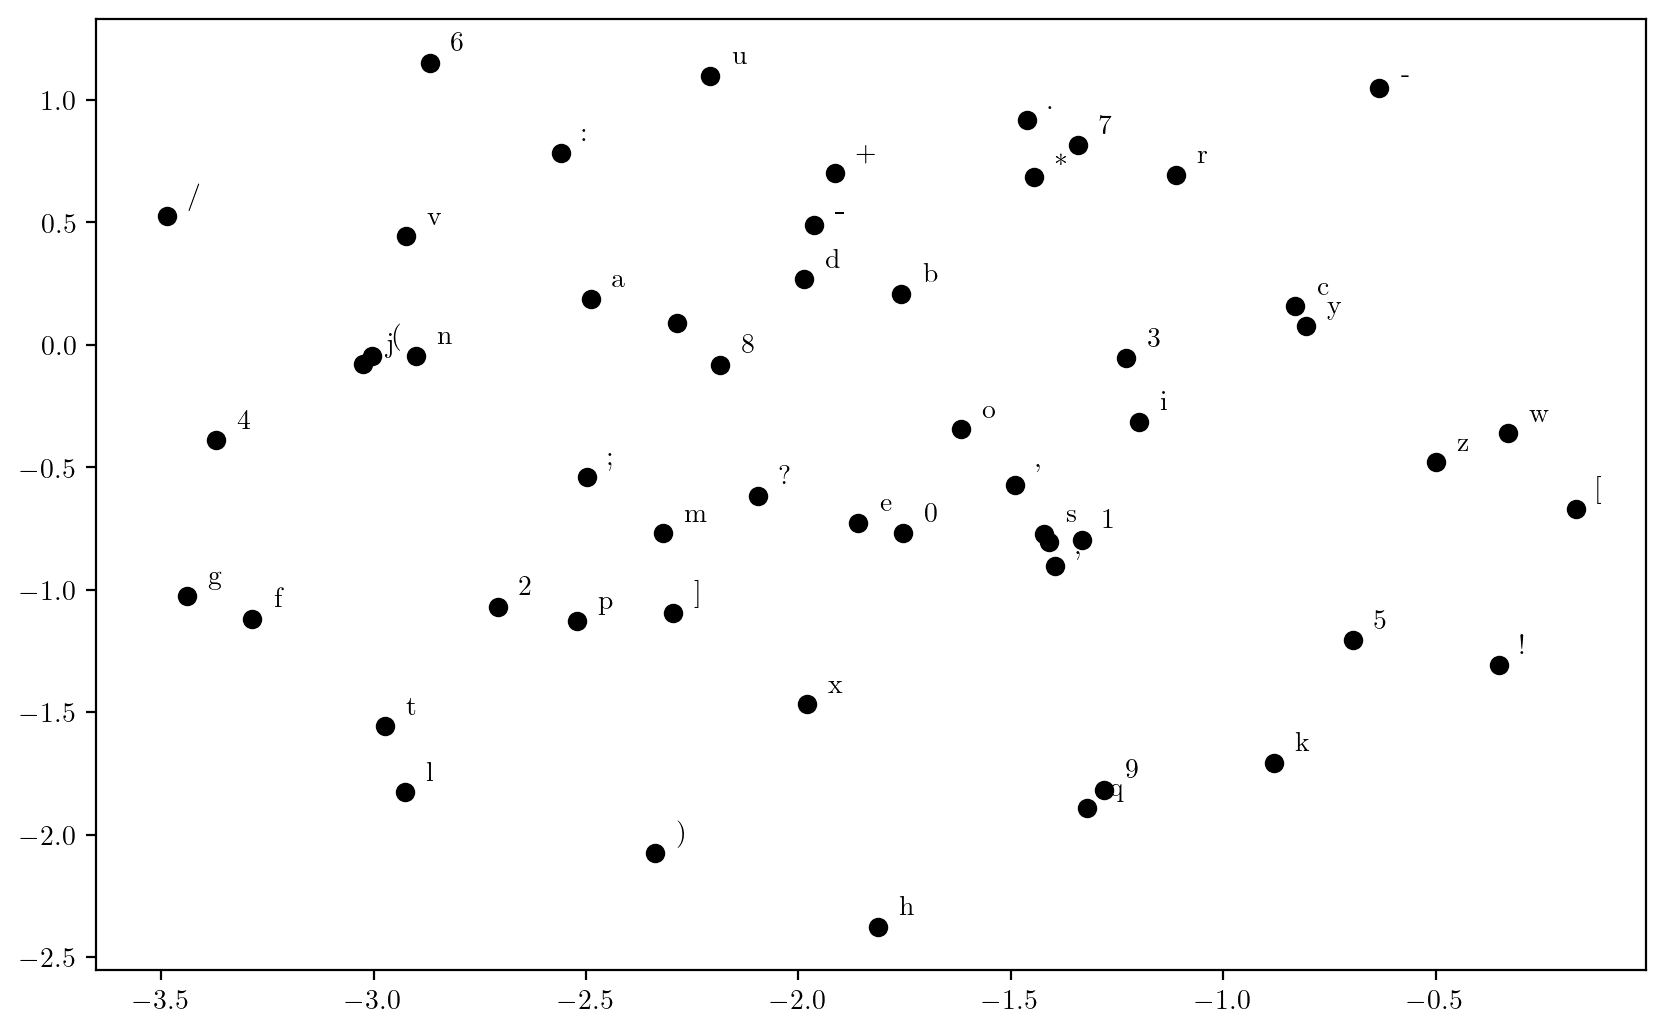

In [79]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax = None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./media/Embed.svg)
![Alt](./media/ModelEmbed.svg)

In [80]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size1, hidden_size2):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = torch.tanh(self.lin2(x))
    x = self.lin3(x)
    return x

In [81]:
model = NextChar(block_size, len(stoi), emb_dim, 100, 75).to(device)
model = torch.compile(model)

In [82]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([54, 50])
_orig_mod.lin1.weight torch.Size([100, 1000])
_orig_mod.lin1.bias torch.Size([100])
_orig_mod.lin2.weight torch.Size([75, 100])
_orig_mod.lin2.bias torch.Size([75])
_orig_mod.lin3.weight torch.Size([54, 75])
_orig_mod.lin3.bias torch.Size([54])


## Generating names from untrained model

In [84]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(4200)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

my_str = generate_text(model, itos, stoi, block_size, 1000, "this is ")
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

this is nb]ed7q_y5mdc9
 0es?[czpr
kaqad3qx232?rqu3u2(h6)]w61o_dhr5'?_['(!-x.ra/.gcs_n1_k *lb?v?rpe;q![vtimyy(-(,
!,lwi8p8n
9;jdxtp1xaw2*[.p[70[p3t;gs91,6mvn*ux438bw7b'j
k3:dxm_
 ,/801(l3*2-m.-91?!lveu
;-)n5j6! ?8u,v8+:?ly60m'l(hgib/o'y;g0un((1xshtsaql:wgj!ba!28cse)c+urk]i40)ez9v?6w]!/g:!/.i-jrnpxnv2 vx/3s+9l_+'g.[_acprnd[*!9-4r8t2x7!,k12/p
/.um[g+t;d 4a*s!:x5z74?1n8*0asel400c9v9;l1_zbd!amhjne;66okl)ffu]qi0v-u3o3uaw8isp
[r3ug(:rf*hw*ag;2[[v/p?pe8,gfhxza4bd4h!7(9[yu].u,i ,9nz_0uqpq3vm3!au1'c'p!2w1r(/52y[oee

p d(shh?c!mzhme4++nxwy67/+1;w29hxt
vx
9jt/ju-adg7;dzq5u7fd8!?os]-u'lh]cwy?/1e+jrqy+q'8wd(+
84pf7;/
f0p.51-ra-qf3-iy/0qw2q/.hw
xodd1vok
[_4i(5-ui.j?q5c,x,;9+ck[nk(5w; ]-'odb4q/-(7x7+vqc_18hbt9()by[qrp/bn
)d1jw+ 2_kt2ry'n1r+/['_m!;5b225f,29!57)m/qmkf),2y9/_pahvim8ls2s.i.
z67w+8bb+5.?/p11
! ,(ngepe.;lh(qp5?7s09:5dg4a942j(?r!x*f5(m-3
i!*ql1*+__93wj's*jq'tmmd*o.i+w 8*;w-bclf
8g'8h)+rj_]x_dd* 87k1n4aih[-!l5[(59
ls9dioer*b40(uj?/gn?n
p,/s?tvo+ [u(n1l'3cd);(pv33)g9[8y/'70lf_*33]!!x'
iaj(__q+

## Model Training

In [85]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.02)
batch_size = 4096
print_every = 100
for epoch in range(10000):
  total_loss = 0
  for i in range(0, X.shape[0], batch_size):
      x = X[i : i + batch_size]
      y = Y[i : i + batch_size]
      y_pred = model(x)
      loss = loss_fn(y_pred.view(-1, len(stoi)), y.view(-1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  if epoch % print_every == 0:
      average_loss = total_loss / (X.shape[0] / batch_size)
      print(f"Epoch {epoch}, Loss: {average_loss}")

Epoch 0, Loss: 2.5646004674881695
Epoch 100, Loss: 1.6162971936845898
Epoch 200, Loss: 1.5689996333294627
Epoch 300, Loss: 1.552300372582629
Epoch 400, Loss: 1.5313422992467687
Epoch 500, Loss: 1.5228890246716424
Epoch 600, Loss: 1.5178785517568847
Epoch 700, Loss: 1.5173129573239397
Epoch 800, Loss: 1.5122716906043527
Epoch 900, Loss: 1.512690740156978
Epoch 1000, Loss: 1.5070035754145477


KeyboardInterrupt: 

## **Saving the model**

In [86]:
torch.save(model.state_dict(), "modelGulliver20_50.pth")

In [87]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[-0.0826,  0.8177,  0.8053,  ..., -0.4778,  0.3350,  0.7782],
                      [-0.5508,  0.0170,  0.0082,  ...,  0.1426,  0.2444, -0.1413],
                      [-0.0269,  0.0320, -0.0826,  ...,  0.0601, -0.0102,  0.0378],
                      ...,
                      [-3.6801,  0.1027, -0.2057,  ...,  0.0271, -0.4896,  0.6726],
                      [-0.1380, -0.0806,  0.0523,  ...,  0.1241,  0.7805, -1.0118],
                      [-0.5757,  1.2184,  0.1446,  ..., -0.1055, -0.7906, -0.0632]],
                     device='cuda:0')),
             ('_orig_mod.lin1.weight',
              tensor([[ 0.3785, -1.0516,  0.6254,  ...,  0.7059, -1.5783, -0.5624],
                      [ 0.0078,  0.4073, -0.0509,  ..., -0.4866, -2.4353, -1.0558],
                      [-0.2776,  0.5777, -0.3408,  ..., -0.7469,  1.6184,  3.5734],
                      ...,
                      [ 0.9878,  0.1626,  0.4817,  ...,  0.2027,  1.9820

## Visualize the Learnt Embedding

<Axes: >

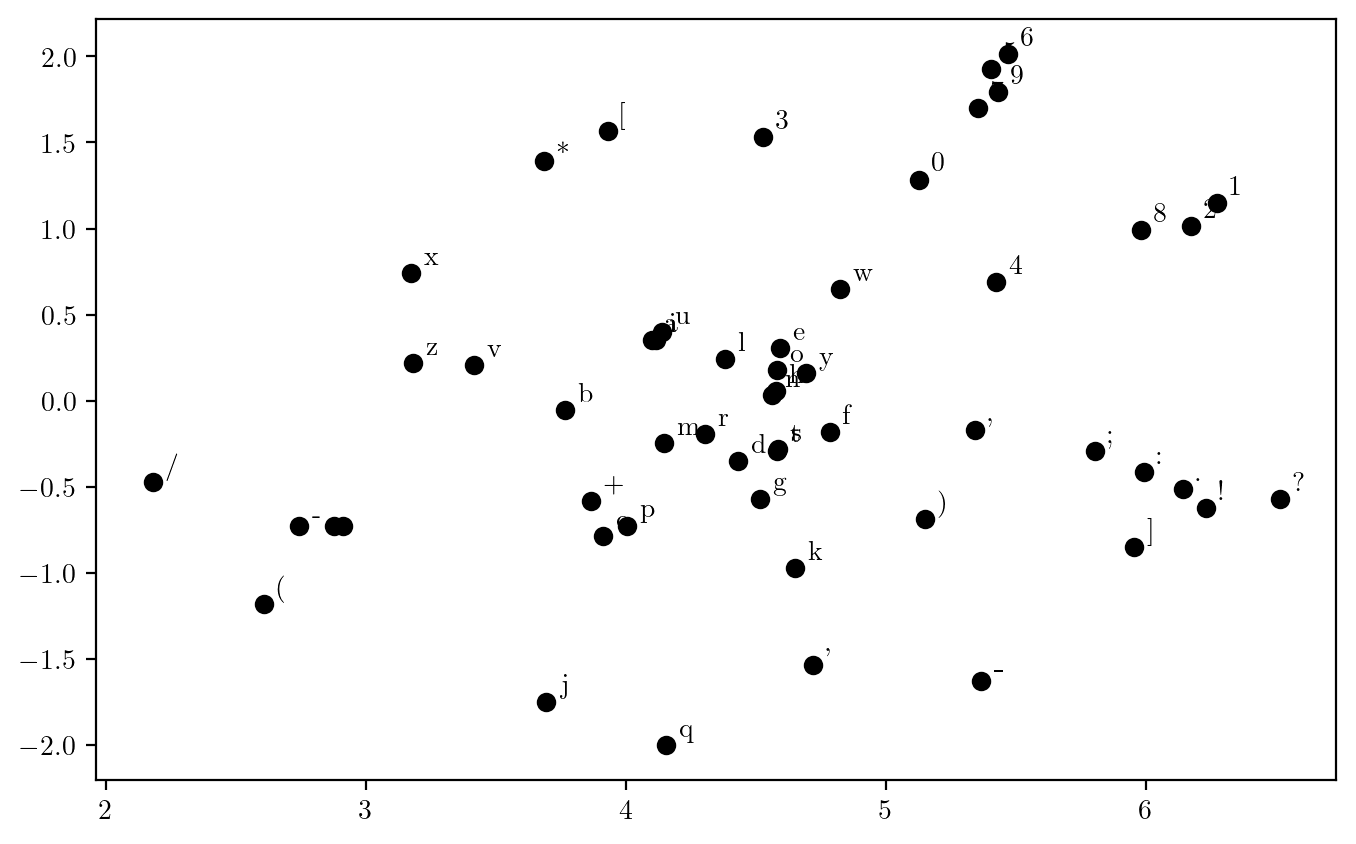

In [88]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [92]:
start = np.random.randint(0, len(new_gulliver) - block_size - 1)
end = start + 100
while new_gulliver[start] != " ":
  start += 1

while new_gulliver[end] != " ":
  end -= 1

seed_text = new_gulliver[start + 1 : end]
print(f"==================Seed Text=================\n{seed_text}\n")
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(f"\n===============Predicted Text===============\n{decoded_string}")

==================Seed Text=================
directly upwards. when the position of the
stone is oblique, the motion of the island is so too.


===============Predicted Text===============
directly upwards. when the position of the
stone is oblique, the motion of the island is so too.
but in know suvoubed england about in the usang sighted leone, play reading to persood of these, to matters a brederges to mone in ussing it; my found affects the country? and page, and les difllilf tending the mocaptments, and incrufal to se. iclest quited to turn a bicl. i tlought
cated wu went for would left him
isstituder
my could not it attended frigin i had day, and her meveren, in proper in att ansmal; and there coat him
sour, to she all an wishour, instpuned to wererdy and we
samealf ongu
ade a law seenp, alties of atter
from thelvened many doing as an arise, where i could not so anceading and ach fankece justing me, and dull were
rever the stem, and were redches on found i plaption bairs pold.

b